In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
import os
import numpy as np
from tensorflow.image import resize_with_pad, grayscale_to_rgb
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential

PATH = "/mnt/d/Datasets/mini-DDSM/"
imgPATH = PATH + "MINI-DDSM-Complete-PNG-16/"
roi_path = PATH + "ROI/"
data_path = PATH + "fullimg/"
save_dir = "/home/jj/FYP/Models/"
image_size = 224
batch_size = 1

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'

2023-01-27 02:51:20.769948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 02:51:21.956682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64
2023-01-27 02:51:21.956852: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared ob

In [2]:
tf.keras.backend.clear_session()

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_path,
  # data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_path,
  # data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)


Found 2830 files belonging to 2 classes.
Using 2264 files for training.


2023-01-27 02:51:27.227743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 02:51:27.229273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-27 02:51:27.229320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-27 02:51:27.229335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

Found 2830 files belonging to 2 classes.
Using 566 files for validation.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
# def prepare(ds, shuffle=False, augment=False):
#   # # Resize and rescale all datasets.
  
#   data_augmentation = tf.keras.Sequential([
#   # Input(shape=(None,None,3)),
#   tf.keras.layers.RandomFlip('horizontal_and_vertical'),
#   tf.keras.layers.RandomRotation((0,0.3),fill_mode="constant"),
#   tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="constant"),
#   tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="constant")
#   ])
#   if shuffle:
#     ds = ds.shuffle(1000)

#   # Batch all datasets.
#   # ds = ds.batch(batch_size)

#   # Use data augmentation only on the training set.
#   if augment:
#     # ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#     #           num_parallel_calls=AUTOTUNE)
#     ds = ds.map(lambda x, y: (data_augmentation(x,training=True),y), 
#                 num_parallel_calls=AUTOTUNE)

#   # Use buffered prefetching on all datasets.
#   return ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
train_ds_aug = train_ds.prefetch(buffer_size=AUTOTUNE).shuffle(1000)
val_ds_aug = val_ds.prefetch(buffer_size=AUTOTUNE).shuffle(1000)

## Just used for once to further train model


In [6]:
# model = load_model("InceptionV3_0.6")
# model.compile(
#     optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
# )
# checkpoint_path = "training2_checkpoint/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq='epoch')
# total_epochs = 100
# history_init = model.fit(train_ds_aug
#                     ,epochs=total_epochs
#                     ,validation_data=val_ds
#                     ,callbacks = [cp_callback]
#                     )
# plt.plot(history_init.history['val_loss'])

In [7]:
# model.save(save_dir+"InceptionV3_training_2")

# Training dense layers to categorise output from CNN models

In [8]:
# pre_trained = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(512,512,3))
# pre_trained.trainable = False
# # pre_trained.trainable = True
# for layer in pre_trained.layers[-64:]:
#   if isinstance(layer, tf.keras.layers.BatchNormalization):
#       layer.trainable = True
# pre_trained.summary()

In [9]:
preprocessing = tf.keras.applications.inception_v3.preprocess_input
pre_trained = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
pre_trained.trainable = False
# pre_trained.trainable = True
# for layer in pre_trained.layers[-64:]:
#   if isinstance(layer, tf.keras.layers.BatchNormalization):
#       layer.trainable = True
# for layer in pre_trained.layers[:-64]:
#   layer.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.),fill_mode="reflect"),
  tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="reflect"),
  tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="reflect")
  ])
#Define model architect
tfinput = Input(shape=(image_size,image_size,3) )
# pre_process = preprocessing(tfinput)
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
inceptionv3_model=pre_trained(pre_process,training=False)
flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
DO1 = Dropout(0.8)(flatten)
Dense1 = Dense(1024,activation = 'relu')(DO1)
# DO2 = Dropout(0.8)(Dense1)
# DO2 = Dropout(0.8)(flatten)
x=Dropout(0.7)(Dense1)
x = Dense(512,activation='relu')(x)
# x=Dropout(0.7)(x)
# x = Dense(256,activation='relu')(x)
# x=Dropout(0.5)(x)
# x = Dense(16,activation="relu")(x)
# x=Dropout(0.5)(x)
# x = Dense(4,activation='relu')(x)
DO2 = Dropout(0.7)(x)
output = Dense(1, activation="sigmoid")(DO2)
model = Model(tfinput,output)
#Prevent overfitting with early stopping
# Earlystop = tf.keras.callbacks.EarlyStopping( monitor='val_accuracy'
#                                               ,patience=10
#                                               # ,start_from_epoch = 0
#                                               # ,baseline = 0.7
#                                               ,restore_best_weights = True
#                                               ,verbose = 1
#                                               )
# Checkpoint = tf.keras.callbacks.ModelCheckpoint(  
#                                                   filepath="/home/jj/FYP/Pass_test/Checkpoint/inceptionv3_categoriser_best_model"
#                                                 , save_weights_only=True
#                                                 , monitor='val_loss'
#                                                 , mode = 'min'
#                                                 , save_best_only=True
#                                                 , verbose=1
#                                                 )
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

# Load weights from previous training 

In [10]:
# model.load_weights("training2_checkpoint/cp-0042.ckpt")

In [12]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [13]:
checkpoint_path = "/home/jj/FYP/Checkpoint/dense_init_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

Epoch 1/10


2023-01-25 23:43:10.359274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 67 of 1000
2023-01-25 23:43:20.382493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 138 of 1000
2023-01-25 23:43:30.206574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 205 of 1000
2023-01-25 23:43:40.309736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 271 of 1000
2023-01-25 23:43:40.646547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-25 23:43:41.799125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-25 23:43:44.808754: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller 

283/283 [==============================] - ETA: 0s - loss: 1.6331 - binary_accuracy: 0.5053 - false_positives: 556.0000 - false_negatives: 564.0000
Epoch 1: saving model to /home/jj/FYP/Checkpoint/dense_init_checkpoint/cp-0001.ckpt


2023-01-25 23:44:20.629883: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-25 23:44:20.629931: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


283/283 [==============================] - 87s 131ms/step - loss: 1.6331 - binary_accuracy: 0.5053 - false_positives: 556.0000 - false_negatives: 564.0000 - val_loss: 0.6918 - val_binary_accuracy: 0.5353 - val_false_positives: 237.0000 - val_false_negatives: 26.0000
Epoch 2/10
283/283 [==============================] - ETA: 0s - loss: 1.2657 - binary_accuracy: 0.5053 - false_positives: 581.0000 - false_negatives: 539.0000
Epoch 2: saving model to /home/jj/FYP/Checkpoint/dense_init_checkpoint/cp-0002.ckpt
283/283 [==============================] - 28s 88ms/step - loss: 1.2657 - binary_accuracy: 0.5053 - false_positives: 581.0000 - false_negatives: 539.0000 - val_loss: 0.6880 - val_binary_accuracy: 0.5353 - val_false_positives: 216.0000 - val_false_negatives: 47.0000
Epoch 3/10
283/283 [==============================] - ETA: 0s - loss: 1.1306 - binary_accuracy: 0.4947 - false_positives: 577.0000 - false_negatives: 567.0000
Epoch 3: saving model to /home/jj/FYP/Checkpoint/dense_init_check

NameError: name 'history_init' is not defined

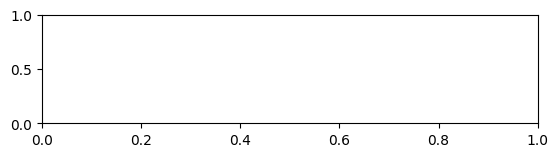

In [14]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
total_epochs = 10
dense_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(dense_init.history['loss'])
plt.subplot(132)
plt.plot(dense_init.history['val_loss'])
plt.subplot(133)
plt.plot(dense_init.history['val_binary_accuracy'])

In [10]:
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-64]:
  layer.trainable = False
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [11]:
model.load_weights("/home/jj/FYP/Checkpoint/fine_tuning_training_checkpoint/cp-0049.ckpt")
# model.load_weights("/home/jj/FYP/Checkpoint/full_model_training_checkpoint/cp-0020.ckpt")
# train_ds.batch(2)
# # val_ds.batch(2)
# train_ds_aug = train_ds.prefetch(AUTOTUNE).shuffle(1000)
# val_ds_aug = val_ds.prefetch(AUTOTUNE).shuffle(1000)

In [13]:
# train_ds_aug.batch(1)
# val_ds.batch(1)
checkpoint_path = "/home/jj/FYP/Checkpoint/fine_tuning_training_2_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

Epoch 1/100


2023-01-27 02:52:34.841059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 441 of 1000
2023-01-27 02:52:44.913013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 897 of 1000
2023-01-27 02:52:47.090782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-27 02:52:48.064777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-27 02:52:51.083653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-27 02:52:51.103982: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f49c670dbd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-27 02:52:51.104010: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor devi

2263/2264 [============================>.] - ETA: 0s - loss: 0.6190 - binary_accuracy: 0.6571 - false_positives: 212.0000 - false_negatives: 564.0000

2023-01-27 02:54:20.499001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 430 of 1000
2023-01-27 02:54:23.589591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 1: saving model to /home/jj/FYP/Checkpoint/fine_tuning_training_2_checkpoint/cp-0001.ckpt
2264/2264 [==============================] - 135s 45ms/step - loss: 0.6189 - binary_accuracy: 0.6572 - false_positives: 212.0000 - false_negatives: 564.0000 - val_loss: 0.5974 - val_binary_accuracy: 0.6926 - val_false_positives: 34.0000 - val_false_negatives: 140.0000
Epoch 2/100
2264/2264 [==============================] - ETA: 0s - loss: 0.5978 - binary_accuracy: 0.6652 - false_positives: 221.0000 - false_negatives: 537.0000
Epoch 2: saving model to /home/jj/FYP/Checkpoint/fine_tuning_training_2_checkpoint/cp-0002.ckpt
2264/2264 [==============================] - 87s 38ms/step - loss: 0.5978 - binary_accuracy: 0.6652 - false_positives: 221.0000 - false_negatives: 537.0000 - val_loss: 0.6034 - val_binary_accuracy: 0.7014 - val_false_positives: 52.0000 - val_false_negatives: 117.0000
Epoch 3/100
2263/2264 [============================>.] - ETA: 0s - loss: 0.5914 - binary_accuracy: 0.6783 - 

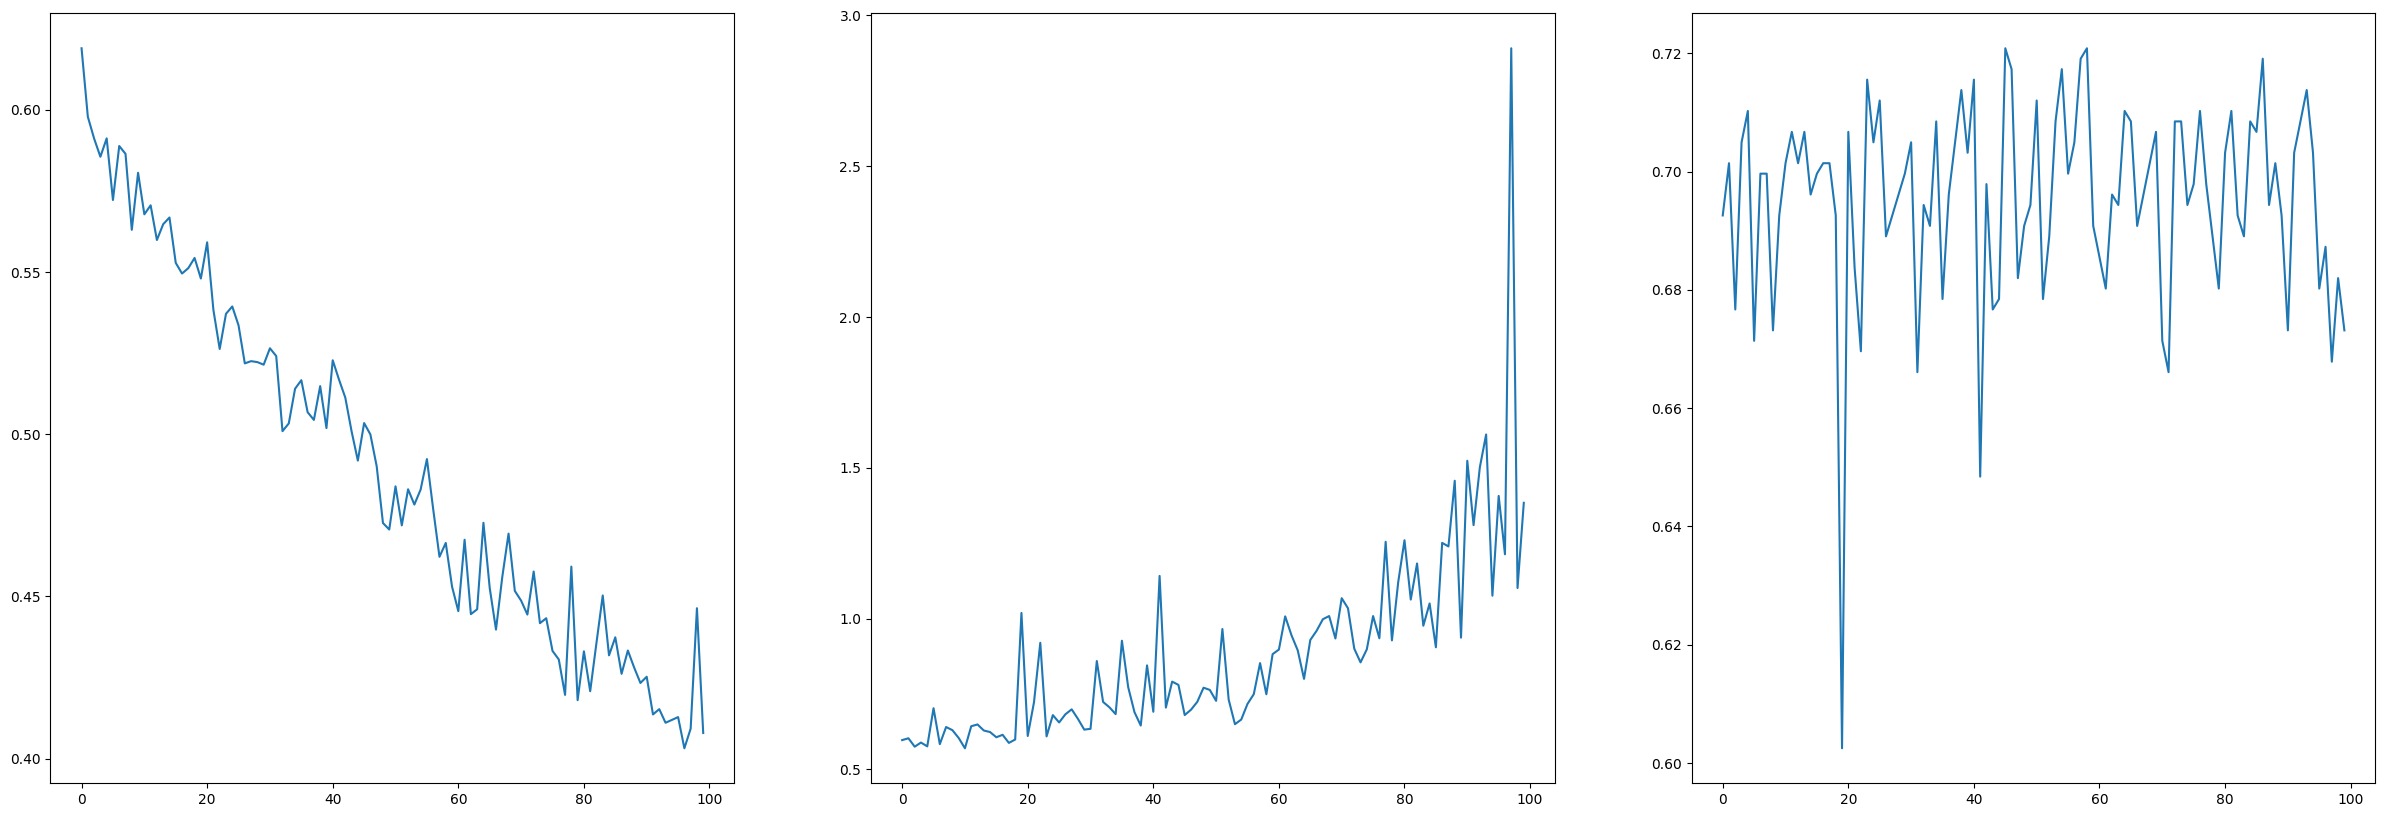

: 

In [14]:
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

2023-01-26 08:44:59.206799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-26 08:45:01.220365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-26 08:45:01.227734: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f146c001c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 08:45:01.227756: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-01-26 08:45:01.231951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-26 08:45:01.310701: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime 

2264/2264 [==============================] - ETA: 0s - loss: 0.6956 - binary_accuracy: 0.4898 - false_positives: 74.0000 - false_negatives: 1081.0000
Epoch 1: saving model to /home/jj/FYP/Checkpoint/full_model_training_checkpoint/cp-0001.ckpt
2264/2264 [==============================] - 152s 59ms/step - loss: 0.6956 - binary_accuracy: 0.4898 - false_positives: 74.0000 - false_negatives: 1081.0000 - val_loss: 0.6933 - val_binary_accuracy: 0.4929 - val_false_positives: 0.0000e+00 - val_false_negatives: 287.0000
Epoch 2/50
2264/2264 [==============================] - ETA: 0s - loss: 0.6962 - binary_accuracy: 0.4943 - false_positives: 230.0000 - false_negatives: 915.0000
Epoch 2: saving model to /home/jj/FYP/Checkpoint/full_model_training_checkpoint/cp-0002.ckpt
2264/2264 [==============================] - 134s 59ms/step - loss: 0.6962 - binary_accuracy: 0.4943 - false_positives: 230.0000 - false_negatives: 915.0000 - val_loss: 0.6933 - val_binary_accuracy: 0.4929 - val_false_positives: 0.

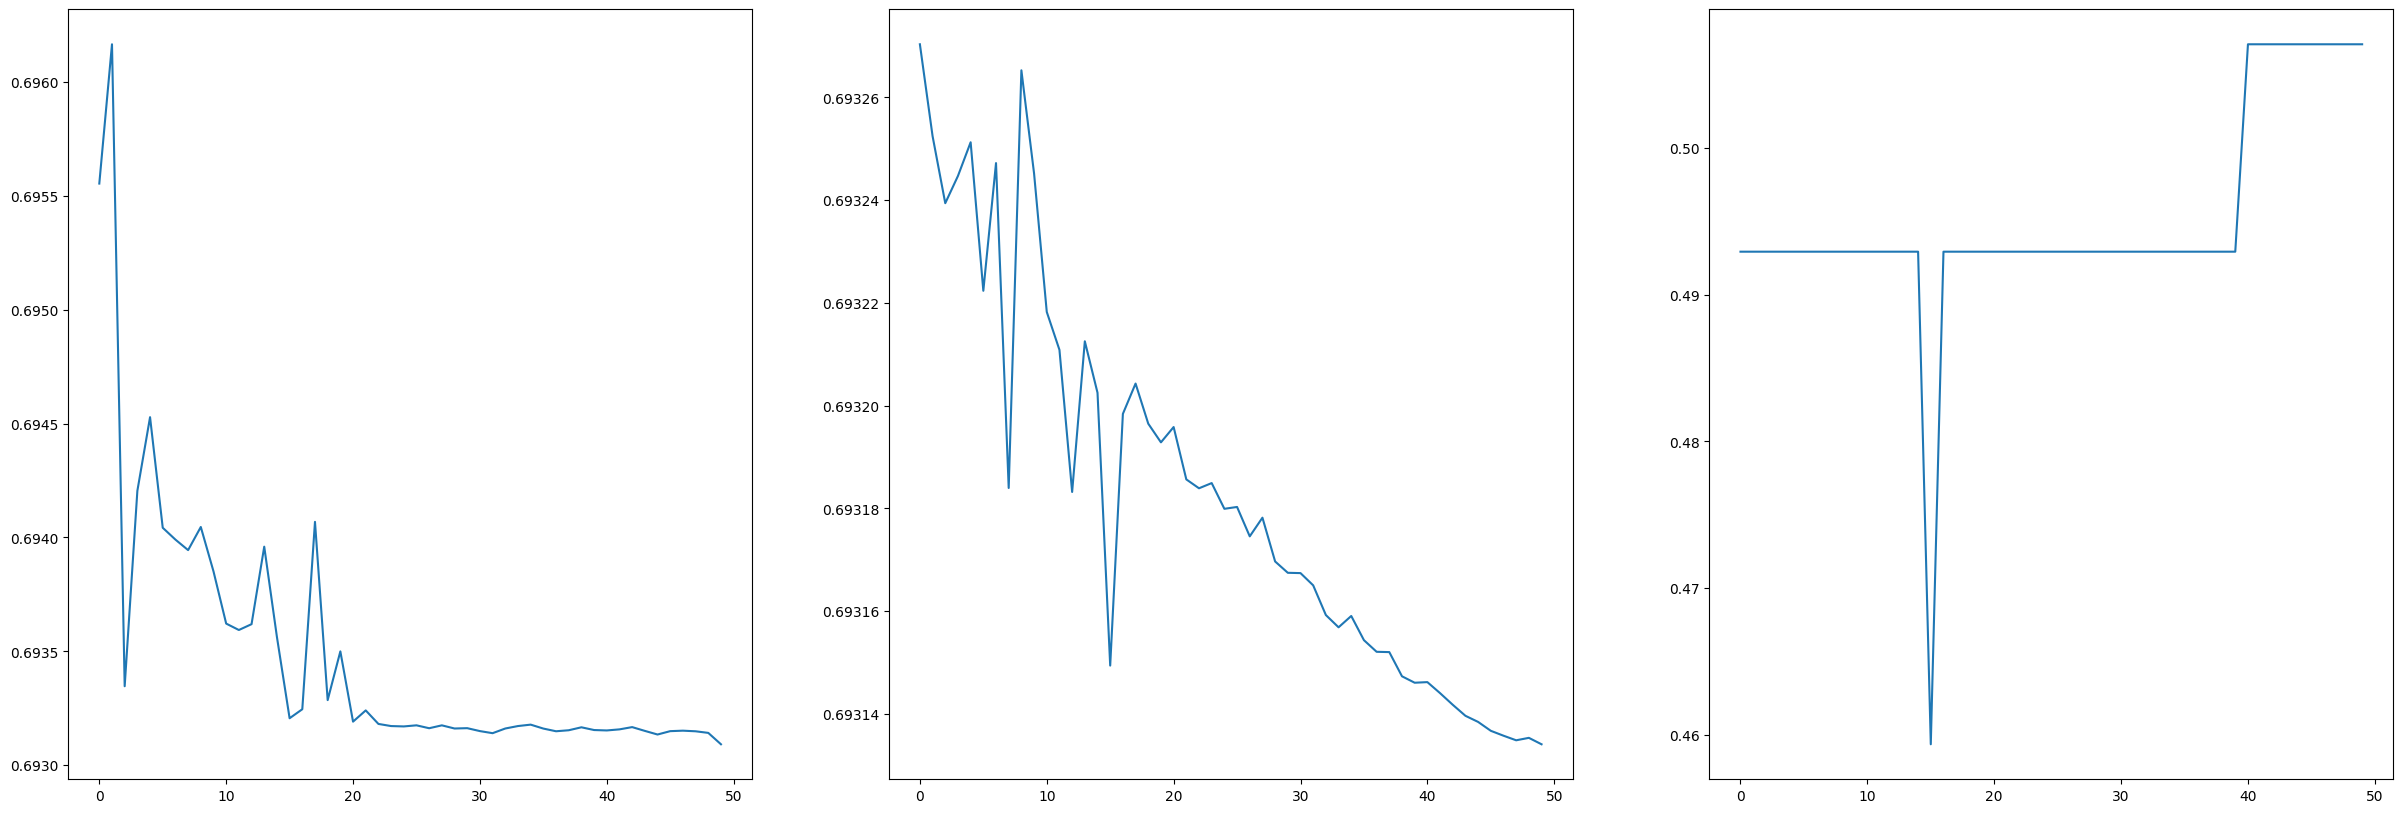

In [10]:
tf.keras.backend.clear_session()
model.load_weights("/home/jj/FYP/Checkpoint/full_model_training_checkpoint/cp-0020.ckpt")
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/full_model_training_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 50
full_model_history = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(full_model_history.history['loss'])
plt.subplot(132)
plt.plot(full_model_history.history['val_loss'])
plt.subplot(133)
plt.plot(full_model_history.history['val_binary_accuracy'])

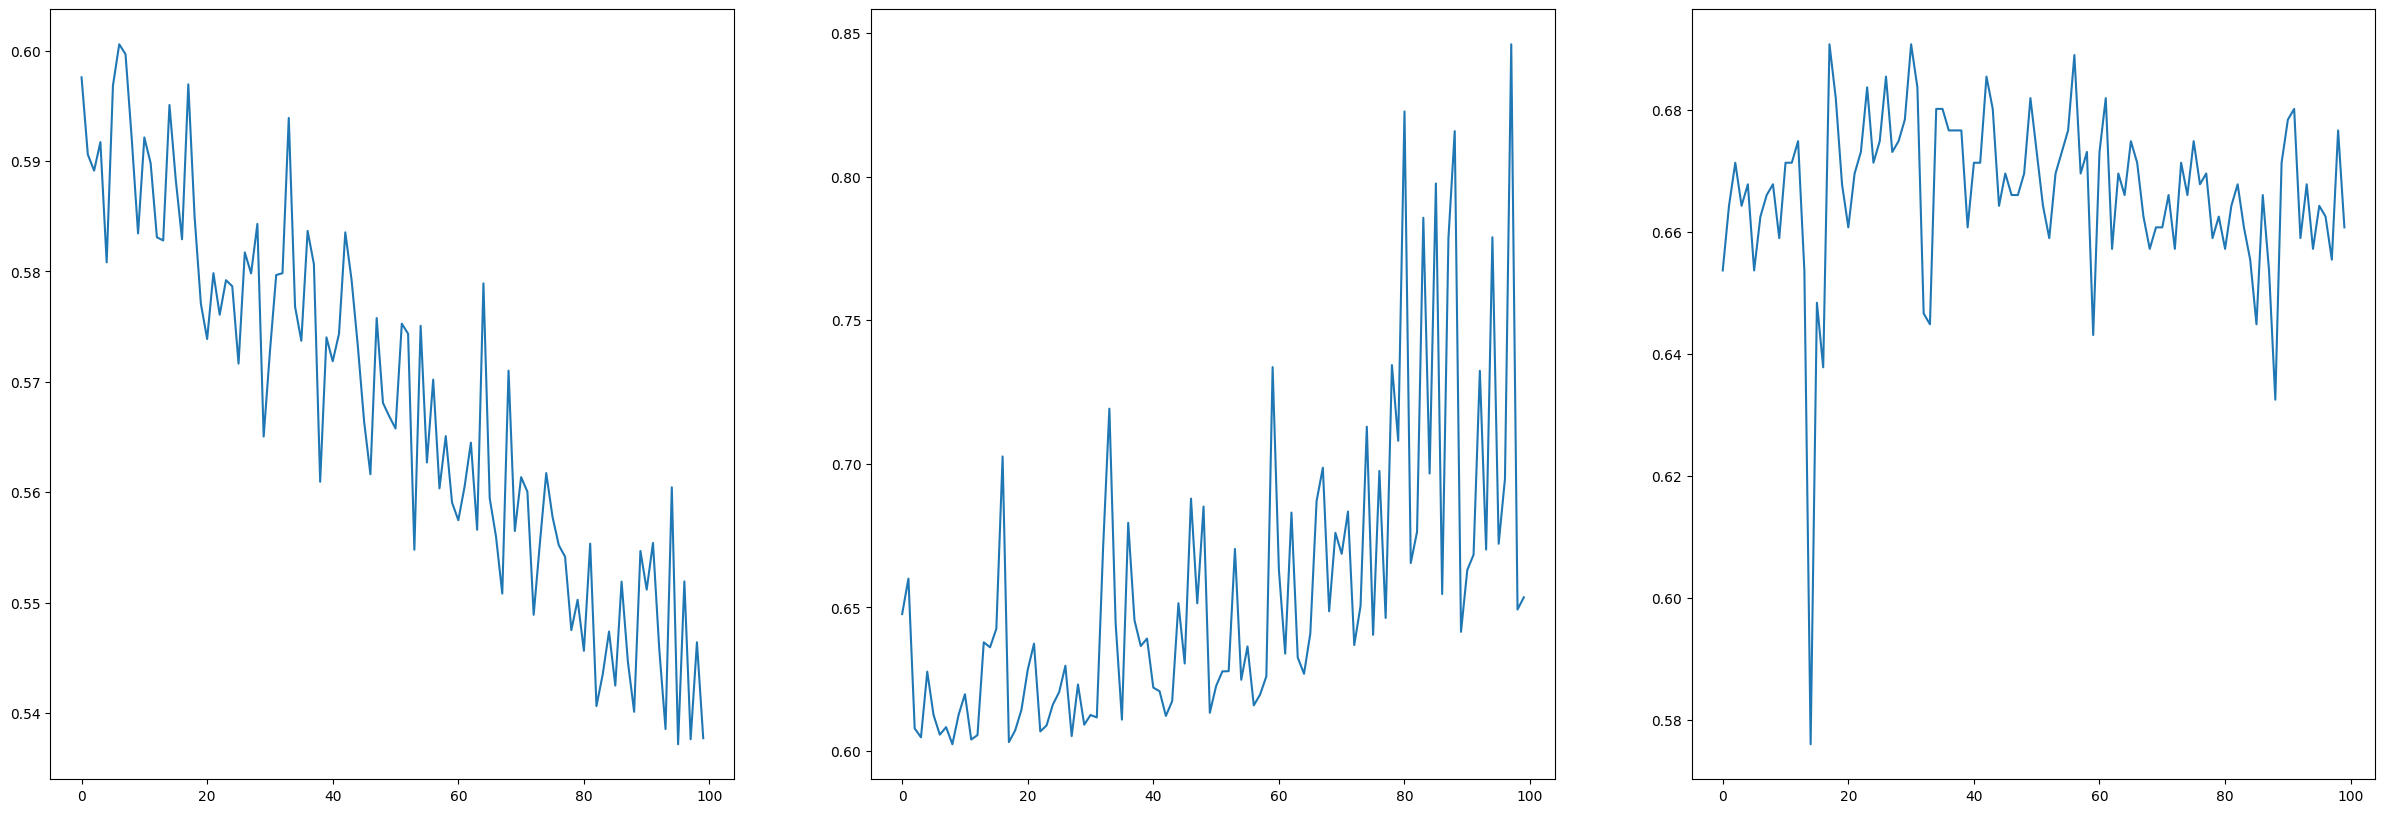

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

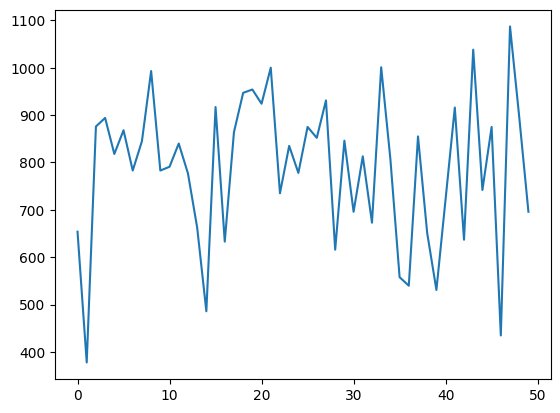

In [15]:
plt.plot(history_init.history['false_positives'])

In [8]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds
                    # ,callbacks = [Checkpoint]
                    )
# model.save(save_dir + "inceptionv3")
plt.plot(history_init.history['val_loss'])

Epoch 1/100


2023-01-20 07:23:22.331538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 83 of 1000
2023-01-20 07:23:32.334070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 176 of 1000
2023-01-20 07:23:42.275166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 270 of 1000
2023-01-20 07:23:42.757624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


283/283 [==============================] - 62s 110ms/step - loss: 5.6574 - binary_accuracy: 0.5181 - false_positives: 959.0000 - false_negatives: 132.0000 - val_loss: 0.6934 - val_binary_accuracy: 0.5071 - val_false_positives: 279.0000 - val_false_negatives: 0.0000e+00
Epoch 2/100
283/283 [==============================] - 27s 87ms/step - loss: 5.5587 - binary_accuracy: 0.5049 - false_positives: 974.0000 - false_negatives: 147.0000 - val_loss: 0.6935 - val_binary_accuracy: 0.5071 - val_false_positives: 279.0000 - val_false_negatives: 0.0000e+00
Epoch 3/100
283/283 [==============================] - 27s 87ms/step - loss: 6.5216 - binary_accuracy: 0.5013 - false_positives: 965.0000 - false_negatives: 164.0000 - val_loss: 0.6934 - val_binary_accuracy: 0.5071 - val_false_positives: 279.0000 - val_false_negatives: 0.0000e+00
Epoch 4/100
283/283 [==============================] - 27s 87ms/step - loss: 5.7427 - binary_accuracy: 0.4951 - false_positives: 996.0000 - false_negatives: 147.0000 - 

: 

: 

In [ ]:
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-64]:
  layer.trainable = False
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
    # ,jit_compile = True
)
model.summary()
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds
                    # ,callbacks = [Checkpoint]
                    )
# model.save(save_dir + "inceptionv3")
plt.plot(history_init.history['val_loss'])

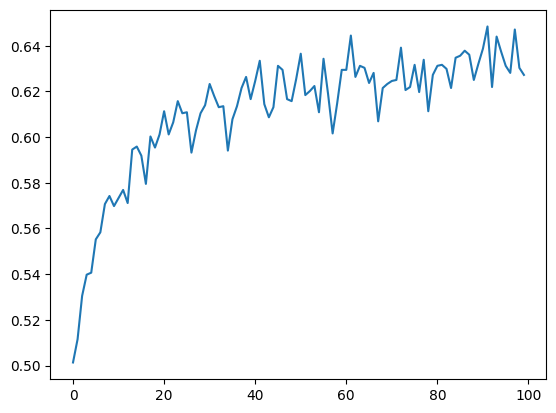

In [8]:
plt.plot(history_init.history['accuracy'])

Train and save categoriser(Dense layers)

Load into model to continue training

In [7]:
inceptionv3_categoriser_input = model.get_layer(name = "dropout").get_output_at(0)
inceptionv3_categoriser_output = model.get_layer(name = "dense_1").get_output_at(0)
inceptionv3_categoriser = Model(inceptionv3_categoriser_input, inceptionv3_categoriser_output)
# inceptionv3_categoriser.summary()
inceptionv3_categoriser.save("/home/jj/FYP/Pass_test/incpetionv3_categoriser_2")

INFO:tensorflow:Assets written to: /home/jj/FYP/Pass_test/incpetionv3_categoriser_2/assets


# Load categoriser into model for fine tuning

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.3),fill_mode="constant"),
  tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="constant"),
  tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="constant")
  ])
preprocessing = tf.keras.applications.inception_v3.preprocess_input
pre_trained = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
pre_trained.trainable = True
for layer in pre_trained.layers[:-64]:
    layer.trainable = False
tfinput = Input(shape=(image_size,image_size,3) )
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
inceptionv3_model=pre_trained(pre_process,training=False)
categoriser = load_model("/home/jj/FYP/Pass_test/incpetionv3_categoriser_2")
pooling = GlobalAveragePooling2D()(inceptionv3_model)
output = categoriser(pooling,training=True)
model = Model(tfinput,output)
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
# Earlystop = tf.keras.callbacks.EarlyStopping( monitor='val_accuracy'
#                                               ,patience=10
#                                               # ,start_from_epoch = 20
#                                               # ,baseline = 0.7
#                                               ,restore_best_weights = True
#                                               ,verbose = 1
#                                               )
model.summary()

Checkpoint = tf.keras.callbacks.ModelCheckpoint(  
                                                  filepath="/home/jj/FYP/Pass_test/Checkpoint/inceptionv3_best_model"
                                                , save_weights_only=True
                                                , monitor='val_loss'
                                                , mode = 'min'
                                                , save_best_only=True
                                                , verbose=1
                                                )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [9]:
total_epochs = 100
history_inceptionv3_FT = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds
                    ,callbacks = [Checkpoint]
                    )
# if(history_inceptionv3_init.history['accuracy'])
model.save(save_dir + "Inceptionv3_TL_FT")

Epoch 1/100
283/283 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.6069
Epoch 1: val_loss improved from inf to 0.78963, saving model to /home/jj/FYP/Pass_test/Checkpoint/inceptionv3_best_model
283/283 [==============================] - 38s 94ms/step - loss: 0.6539 - accuracy: 0.6069 - val_loss: 0.7896 - val_accuracy: 0.5919
Epoch 2/100
283/283 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.6073
Epoch 2: val_loss improved from 0.78963 to 0.77036, saving model to /home/jj/FYP/Pass_test/Checkpoint/inceptionv3_best_model
283/283 [==============================] - 29s 92ms/step - loss: 0.6584 - accuracy: 0.6073 - val_loss: 0.7704 - val_accuracy: 0.5954
Epoch 3/100
283/283 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.6091
Epoch 3: val_loss did not improve from 0.77036
283/283 [==============================] - 28s 88ms/step - loss: 0.6607 - accuracy: 0.6091 - val_loss: 0.7809 - val_accuracy: 0.6113
Epoch 4/100
283/2

KeyboardInterrupt: 

In [18]:
x=0
while history_inceptionv3_init.history['accuracy'][-1]<0.8 and x<5:
    start_epoch = history_inceptionv3_init.epoch[-1] + 1
    total_epochs = start_epoch+50
    history_inceptionv3_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds
                    ,callbacks = Earlystop
                    ,initial_epoch=start_epoch
                    )
    if history_inceptionv3_init.history['accuracy'][-1] < 0.6:
        x=x
    else:
        x=x+1
    

Epoch 17/66
283/283 [==============================] - 16s 48ms/step - loss: 0.6159 - accuracy: 0.6533 - val_loss: 0.6159 - val_accuracy: 0.6678
Epoch 18/66
283/283 [==============================] - 16s 48ms/step - loss: 0.6161 - accuracy: 0.6568 - val_loss: 0.6213 - val_accuracy: 0.6802
Epoch 19/66
283/283 [==============================] - 16s 48ms/step - loss: 0.6048 - accuracy: 0.6696 - val_loss: 0.6392 - val_accuracy: 0.6608
Epoch 20/66
283/283 [==============================] - 16s 48ms/step - loss: 0.6080 - accuracy: 0.6599 - val_loss: 0.6215 - val_accuracy: 0.6820
Epoch 21/66
283/283 [==============================] - 16s 48ms/step - loss: 0.5997 - accuracy: 0.6789 - val_loss: 0.6221 - val_accuracy: 0.6784
Epoch 22/66
283/283 [==============================] - 16s 48ms/step - loss: 0.5981 - accuracy: 0.6625 - val_loss: 0.6353 - val_accuracy: 0.6731
Epoch 23/66
283/283 [==============================] - 16s 48ms/step - loss: 0.5954 - accuracy: 0.6670 - val_loss: 0.6113 - val_ac

: 

: 

# Others


In [ ]:
# Freeze all the layers except the last 2 layers
tf.keras.backend.clear_session()
pre_trained.trainable = True
for layer in pre_trained.layers[:-64]:
    layer.trainable = False
# pre_trained.summary()
tfinput = Input(shape=(image_size,image_size,3) )
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
# pre_process = preprocessing(tfinput)
inceptionv3_model=pre_trained(pre_process,training=False)
flatten = GlobalAveragePooling2D()(inceptionv3_model)
# flatten = Flatten()(inceptionv3_model)
# Dense1 = Dense(255, activation="relu")(flatten)
# DO1 = Dropout(0.8)(Dense1)
# Dense2 = Dense(127, activation="relu")(DO1)
# DO2 = Dropout(0.8)(Dense2)

DO1 = Dropout(0.8)(flatten)
Dense1 = Dense(127,activation = 'relu')(DO1)
# DO2 = Dropout(1)(Dense1)

DO2 = Dropout(0.8)(Dense1)
output = Dense(1, activation="sigmoid")(DO2)
model = Model(tfinput,output)
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
model.summary()

In [ ]:
# Earlystop = tf.keras.callbacks.EarlyStopping( monitor='val_accuracy',
#                                               patience=20,
#                                               start_from_epoch = 0,
#                                               # baseline = 0.7,
#                                               # restore_best_weights = True,
#                                               verbose = 1
#                                               )
total_epochs = history_inceptionv3_init.epoch[-1]+1+ 30
history_inceptionv3_ft = model.fit(train_ds
                    ,epochs=total_epochs
                    ,validation_data=val_ds
                    ,initial_epoch=history_inceptionv3_init.epoch[-1]+1
                    # ,callbacks = Earlystop
                    )
model.save(save_dir + "Inceptionv3_TL_FT")


###Other Tests


In [ ]:
tf.keras.backend.clear_session()
preprocessing = tf.keras.applications.inception_v3.preprocess_input
pre_trained = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
# Freeze all the layers except the last 2 layers
for layer in pre_trained.layers[:-64]:
    layer.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.3),fill_mode="constant"),
  tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="constant"),
  tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="constant")
  ])

tfinput = Input(shape=(image_size,image_size,3) )
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
inceptionv3_model=pre_trained(pre_process,training=True)
flatten = Flatten()(inceptionv3_model)
Dense1 = Dense(255, activation="relu")(flatten)
DO1 = Dropout(0.8)(Dense1)
Dense2 = Dense(127, activation="relu")(DO1)
DO2 = Dropout(0.8)(Dense2)
output = Dense(1, activation="sigmoid")(DO2)
model = Model(tfinput,output)

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
model.summary()
total_epochs = 100
history = model.fit(train_ds_aug,
                    epochs=total_epochs,
                    validation_data=val_ds,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
                    )

In [ ]:
tfinput = Input(shape=(image_size,image_size,3) )
print(tfinput)
# x = data_augmentation(tfinput)
x = preprocessing(tfinput)
# print(x)
x=pre_trained(x,training=True)
# print(x)
x = Flatten()(x)
print(x)
x = Dense(255, activation="relu")(x)
x = Dropout(0.8)(x)
x = Dense(127, activation="relu")(x)
x = Dropout(0.8)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(tfinput,output)

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
model.summary()

In [ ]:
history = model.fit(train_ds
                    ,epochs=10
                    ,validation_data=val_ds
                    # ,callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
                    )

In [ ]:
fine_tune_epochs = 10
total_epochs =  history.epoch[-1] + fine_tune_epochs

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Accuracy = history_fine.history['val_loss']
plt.plot(Accuracy)
plt.show()

In [ ]:
fine_tune_epochs = 100
total_epochs =  history.epoch[-1] + fine_tune_epochs

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Accuracy = history_fine.history['val_accuracy']
plt.plot(Accuracy)
plt.show()

In [ ]:
model.save("/home/jj/FYP/Pass_test/mini-DDSM_Inceptionv3_model")

In [ ]:
tf.keras.backend.clear_session()
preprocessing = tf.keras.applications.vgg16.preprocess_input
pre_trained = VGG16(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
# Freeze all the layers except the last 2 layers
for layer in pre_trained.layers[:-12]:
    layer.trainable = False
tfinput = Input(shape=(image_size,image_size,3) )
print(tfinput)
# x = data_augmentation(tfinput)
x = preprocessing(tfinput)
# print(x)
x=pre_trained(x,training=True)
# print(x)
x = Flatten()(x)
print(x)
x = Dense(255, activation="relu")(x)
x = Dropout(0.8)(x)
x = Dense(127, activation="relu")(x)
x = Dropout(0.8)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(tfinput,output)

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
model.summary()
epochs_per_cycle = 10
init_epoch = 1
total_epochs = 10
for i in range(10):
    train_ds_aug = prepare(train_ds, shuffle=True, augment=True)
    history = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=init_epoch,
                         validation_data=val_ds)
    init_epoch = init_epoch + epochs_per_cycle
    total_epochs = total_epochs + epochs_per_cycle

model.save("/home/jj/FYP/Pass_test/mini-DDSM_VGG16_model")

In [ ]:
tf.keras.backend.clear_session()
preprocessing = tf.keras.applications.resnet50.preprocess_input
pre_trained = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
# Freeze all the layers except the last 2 layers
for layer in pre_trained.layers[:-22]:
    layer.trainable = False
tfinput = Input(shape=(image_size,image_size,3) )
print(tfinput)
# x = data_augmentation(tfinput)
x = preprocessing(tfinput)
# print(x)
x=pre_trained(x,training=True)
# print(x)
x = Flatten()(x)
print(x)
x = Dense(255, activation="relu")(x)
x = Dropout(0.8)(x)
x = Dense(127, activation="relu")(x)
x = Dropout(0.8)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(tfinput,output)

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
model.summary()
epochs_per_cycle = 10
init_epoch = 0
total_epochs = 10
for i in range(10):
    train_ds_aug = prepare(train_ds, shuffle=True, augment=True)
    history = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=init_epoch,
                         validation_data=val_ds)
    init_epoch = init_epoch + epochs_per_cycle
    total_epochs = total_epochs + epochs_per_cycle

model.save("/home/jj/FYP/Pass_test/mini-DDSM_resnet50_model")

In [ ]:
tf.keras.backend.clear_session()
preprocessing = tf.keras.applications.inception_v3.preprocess_input
pre_trained = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
# Freeze all the layers except the last 2 layers
for layer in pre_trained.layers[:-64]:
    layer.trainable = False
tfinput = Input(shape=(image_size,image_size,3) )
print(tfinput)
# x = data_augmentation(tfinput)
x = preprocessing(tfinput)
# print(x)
x=pre_trained(x,training=True)
# print(x)
x = Flatten()(x)
print(x)
x = Dense(255, activation="relu")(x)
x = Dropout(0.8)(x)
x = Dense(127, activation="relu")(x)
x = Dropout(0.8)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(tfinput,output)

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
model.summary()
epochs_per_cycle = 10
init_epoch = 0
total_epochs = 10
for i in range(10):
    train_ds_aug = prepare(train_ds, shuffle=True, augment=True)
    history = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=init_epoch,
                         validation_data=val_ds)
    init_epoch = init_epoch + epochs_per_cycle
    total_epochs = total_epochs + epochs_per_cycle

model.save("/home/jj/FYP/Pass_test/mini-DDSM_inceptionv3_model")

In [ ]:
tf.keras.backend.clear_session()
preprocessing = tf.keras.applications.efficientnet_v2.preprocess_input
pre_trained = tf.keras.applications.efficientnet_v2.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
# Freeze all the layers except the last 2 layers
for layer in pre_trained.layers[:-75]:
    layer.trainable = False
tfinput = Input(shape=(image_size,image_size,3) )
print(tfinput)
# x = data_augmentation(tfinput)
x = preprocessing(tfinput)
# print(x)
x=pre_trained(x,training=True)
# print(x)
x = Flatten()(x)
print(x)
x = Dense(255, activation="relu")(x)
x = Dropout(0.8)(x)
x = Dense(127, activation="relu")(x)
x = Dropout(0.8)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(tfinput,output)

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
model.summary()
epochs_per_cycle = 10
init_epoch = 0
total_epochs = 10
for i in range(10):
    train_ds_aug = prepare(train_ds, shuffle=True, augment=True)
    history = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=init_epoch,
                         validation_data=val_ds)
    init_epoch = init_epoch + epochs_per_cycle
    total_epochs = total_epochs + epochs_per_cycle

model.save("/home/jj/FYP/Pass_test/mini-DDSM_efficientnet_v2_model")

In [ ]:
pre_trained = tf.keras.applications.efficientnet_v2.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))